 # Notebook 15: Temporal Trends and Insights
 Analyze bias trends over time

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LinearRegression

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_theme(style="darkgrid")

BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / "data" / "processed"
ALL_FEATURES_FILE = PROCESSED_DIR / "all_features_combined.parquet"

print("Loading combined feature matrix...")
df = pd.read_parquet(ALL_FEATURES_FILE)

print(f"Loaded {len(df):,} articles for longitudinal analysis")

# Ensure we have a proper year column
if "publication_date" in df.columns:
    df["publication_date_parsed_nb15"] = pd.to_datetime(
        df["publication_date"], errors="coerce"
    )
elif "published_date_parsed" in df.columns:
    df["publication_date_parsed_nb15"] = pd.to_datetime(
        df["published_date_parsed"], errors="coerce"
    )
else:
    df["publication_date_parsed_nb15"] = pd.NaT

if "publication_year" in df.columns:
    df["year"] = df["publication_year"]
else:
    df["year"] = df["publication_date_parsed_nb15"].dt.year

df = df.dropna(subset=["year"])
df["year"] = df["year"].astype(int)

# Focus on the main analysis window
df = df[(df["year"] >= 1998) & (df["year"] <= 2025)]
print(
    f"Analysis window: {df['year'].min()} - {df['year'].max()} ({len(df):,} articles)"
)

BIAS_DIMENSIONS = [
    "gender",
    "religion",
    "caste",
    "region",
    "socioeconomic",
    "political",
    "age",
    "disability",
    "urban_rural",
    "language",
]


def get_bias_columns(frame: pd.DataFrame, dim: str):
    """Return (score_col, label_col) for a given bias dimension if present."""
    score_col = (
        f"bias_v2_{dim}_score" if f"bias_v2_{dim}_score" in frame.columns else None
    )
    label_col = (
        f"bias_v2_{dim}_label" if f"bias_v2_{dim}_label" in frame.columns else None
    )

    # Fallback to rule-based flags if V2 not available
    if score_col is None and label_col is None and f"has_{dim}_bias" in frame.columns:
        label_col = f"has_{dim}_bias"

    return score_col, label_col


for dim in BIAS_DIMENSIONS:
    score_c, label_c = get_bias_columns(df, dim)
    if score_c is None and label_c is None:
        print(
            f"Warning: no bias columns found for '{dim}', it will be skipped in some analyses."
        )

 ## 1. 5-Year Period Analysis (aligned with government regimes)


5-year period average bias levels:
period_5y      1998-2002  2003-2007  2008-2012  2013-2017  2018-2022  \
dimension                                                              
age             0.382789   0.359047   0.324978   0.369085   0.407603   
caste           0.073406   0.085748   0.070292   0.069004   0.076905   
disability      0.078918   0.075830   0.073752   0.074579   0.076837   
gender          0.418702   0.377136   0.318143   0.378089   0.385502   
language        0.104831   0.103645   0.088006   0.096472   0.105168   
political       0.383334   0.453414   0.327275   0.396544   0.383952   
region          0.351939   0.341449   0.283354   0.292940   0.343399   
religion        0.173546   0.211889   0.152489   0.170853   0.151467   
socioeconomic   0.139089   0.159753   0.132317   0.134224   0.148167   
urban_rural     0.229160   0.243964   0.209744   0.234680   0.276152   

period_5y      2023-2025  
dimension                 
age             0.408750  
caste           0.

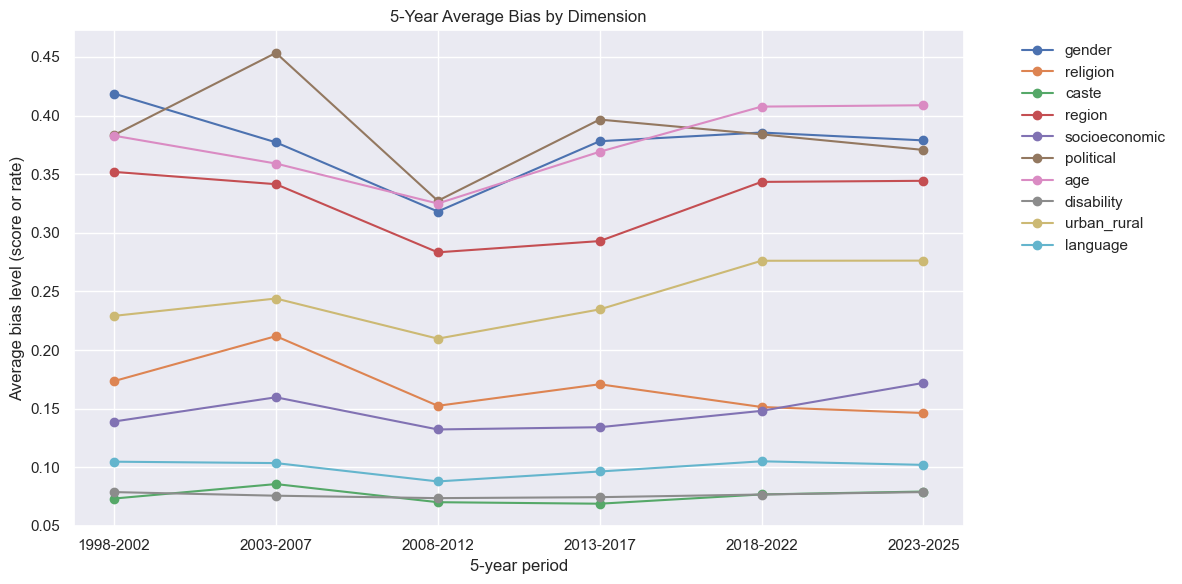

In [ ]:
def assign_five_year_period(year: int) -> str:
    """Map a year to a rolling 5-year period starting from 1998.

    Example: 1998-2002, 2003-2007, 2008-2012, etc.
    """
    if year < 1998:
        return "before-1998"
    start = ((year - 1998) // 5) * 5 + 1998
    end = min(start + 4, 2025)
    return f"{start}-{end}"


df["period_5y"] = df["year"].apply(assign_five_year_period)
df_periods = df[df["period_5y"] != "before-1998"].copy()

period_rows = []
for dim in BIAS_DIMENSIONS:
    score_col, label_col = get_bias_columns(df_periods, dim)
    measure_col = score_col or label_col
    if measure_col is None:
        continue
    grp = df_periods.groupby("period_5y")[measure_col].mean()
    for period, val in grp.items():
        period_rows.append(
            {"dimension": dim, "period_5y": period, "avg_bias": float(val)}
        )

period_summary = pd.DataFrame(period_rows)
if not period_summary.empty:
    print("\n5-year period average bias levels:")
    print(
        period_summary.pivot(index="dimension", columns="period_5y", values="avg_bias")
    )

    plt.figure(figsize=(12, 6))
    for dim in BIAS_DIMENSIONS:
        sub = period_summary[period_summary["dimension"] == dim]
        if sub.empty:
            continue
        sub = sub.sort_values("period_5y")
        plt.plot(sub["period_5y"], sub["avg_bias"], marker="o", label=dim)

    plt.title("5-Year Average Bias by Dimension")
    plt.xlabel("5-year period")
    plt.ylabel("Average bias level (score or rate)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### Key Insights: 5‑Year Average Bias Trends

1) Gender, political, age, and regional bias are persistently highest, with a dip around 2008–2012 and then a rebound, indicating these dimensions have been structurally prominent across the full timeline.

2) Several dimensions show renewed growth in recent years, especially urban–rural and socioeconomic bias (and to a lesser extent disability and language), whose averages rise in 2018–2022 and stay elevated in 2023–2025, suggesting broadening of bias beyond the traditional core categories.

 ## 2. Bias Dimension Evolution Over Time


Yearly bias evolution (head):
  dimension  year  avg_bias
0    gender  1998  0.411656
1    gender  1999  0.409686
2    gender  2000  0.465669
3    gender  2001  0.401121
4    gender  2002  0.400349


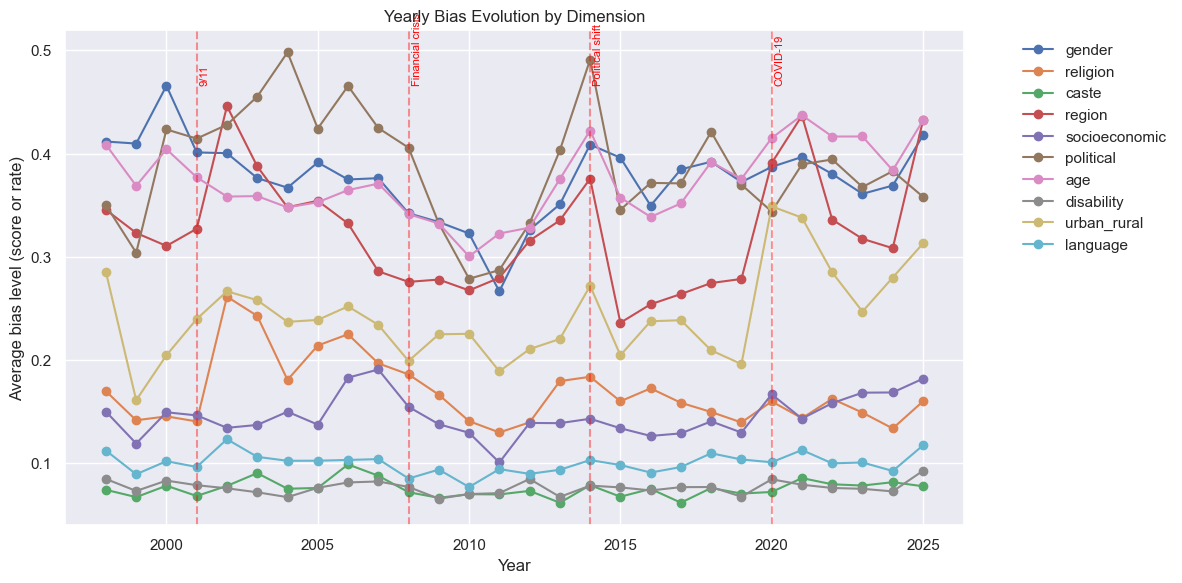

In [ ]:
yearly_rows = []
for dim in BIAS_DIMENSIONS:
    score_col, label_col = get_bias_columns(df, dim)
    measure_col = score_col or label_col
    if measure_col is None:
        continue

    series = df.groupby("year")[measure_col].mean()
    for year, val in series.items():
        yearly_rows.append(
            {"dimension": dim, "year": int(year), "avg_bias": float(val)}
        )

bias_yearly = pd.DataFrame(yearly_rows)

if not bias_yearly.empty:
    print("\nYearly bias evolution (head):")
    print(bias_yearly.head())

    plt.figure(figsize=(12, 6))
    for dim in BIAS_DIMENSIONS:
        sub = bias_yearly[bias_yearly["dimension"] == dim].sort_values("year")
        if sub.empty:
            continue
        plt.plot(sub["year"], sub["avg_bias"], marker="o", label=dim)

    plt.title("Yearly Bias Evolution by Dimension")
    plt.xlabel("Year")
    plt.ylabel("Average bias level (score or rate)")
    for event_year, label in {
        2001: "9/11",
        2008: "Financial crisis",
        2014: "Political shift",
        2020: "COVID-19",
    }.items():
        if (bias_yearly["year"] == event_year).any():
            plt.axvline(event_year, color="red", linestyle="--", alpha=0.4)
            plt.text(
                event_year + 0.1,
                plt.ylim()[1] * 0.9,
                label,
                rotation=90,
                color="red",
                fontsize=8,
            )

    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

### Key Insights: Yearly Bias Evolution by Dimension

1) Gender, political and age bias consistently sit at the top, showing pronounced spikes around major milestones (e.g., 9/11, the financial crisis, political shifts, COVID‑19), while caste, disability and language bias remain comparatively low and stable across years.

2) There is a clear dip in bias around 2009–2012 followed by a renewed rise, with most dimensions climbing again from ~2013 onward—especially regional, socioeconomic and urban–rural bias—indicating that both the intensity and breadth of measured bias have increased in recent years.

 ## 3. Turning Points (Years with Significant Bias Shifts)

In [ ]:
turning_rows = []
for dim in BIAS_DIMENSIONS:
    sub = bias_yearly[bias_yearly["dimension"] == dim].sort_values("year")
    if len(sub) < 2:
        continue
    sub = sub.copy()
    sub["delta"] = sub["avg_bias"].diff()
    for _, row in sub.iterrows():
        if pd.isna(row["delta"]):
            continue
        turning_rows.append(
            {"dimension": dim, "year": int(row["year"]), "delta": float(row["delta"])}
        )

turning_df = pd.DataFrame(turning_rows)

if not turning_df.empty:
    # Top turning points by absolute year-on-year change
    top_turning = turning_df.reindex(
        turning_df["delta"].abs().sort_values(ascending=False).index
    ).head(20)
    print("\nTop 20 turning points in yearly bias levels:")
    print(top_turning)


Top 20 turning points in yearly bias levels:
       dimension  year     delta
237  urban_rural  2020  0.152798
151    political  2015 -0.145480
97        region  2015 -0.139570
216  urban_rural  1999 -0.124142
107       region  2025  0.123754
30      religion  2002  0.120873
136    political  2000  0.119435
84        region  2002  0.118756
102       region  2020  0.112301
104       region  2022 -0.100763
150    political  2014  0.087869
141    political  2005 -0.073796
145    political  2009 -0.073406
149    political  2013  0.070750
232  urban_rural  2015 -0.067331
178          age  2015 -0.064953
2         gender  2001 -0.064548
32      religion  2004 -0.061971
13        gender  2012  0.059642
85        region  2003 -0.058331


 ## 4. Media Maturity and Overall Bias Trend


Media maturity trend (overall bias vs year):
  Linear trend slope: 0.0000 bias units per year
  Pearson correlation (year, bias): 0.019


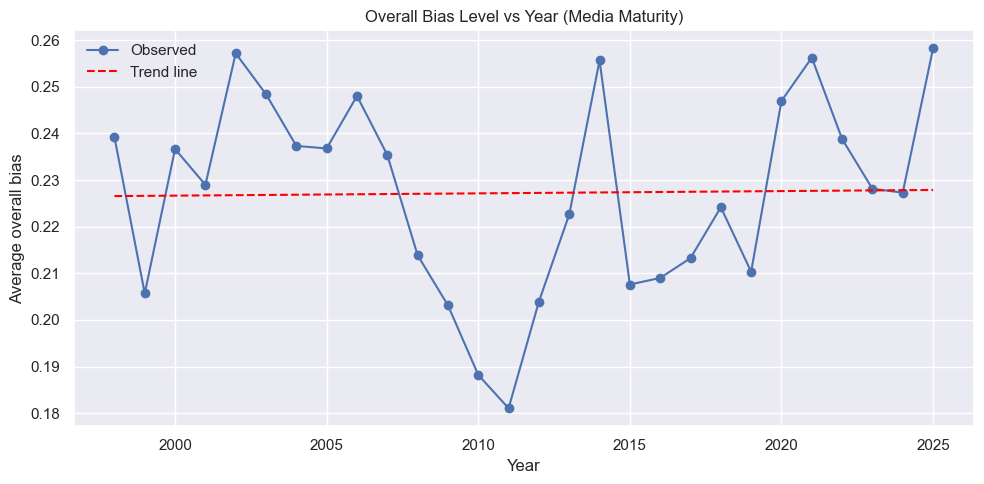

In [ ]:
overall_series = None

if "bias_v2_mean_score" in df.columns:
    overall_series = df.groupby("year")["bias_v2_mean_score"].mean()
else:
    flag_cols = [
        f"has_{dim}_bias" for dim in BIAS_DIMENSIONS if f"has_{dim}_bias" in df.columns
    ]
    if flag_cols:
        overall_series = df.groupby("year")[flag_cols].mean().mean(axis=1)

if overall_series is not None and len(overall_series) >= 2:
    years_arr = overall_series.index.values.reshape(-1, 1)
    values_arr = overall_series.values

    lr_overall = LinearRegression()
    lr_overall.fit(years_arr, values_arr)
    slope = lr_overall.coef_[0]
    corr = np.corrcoef(overall_series.index.values, values_arr)[0, 1]

    print("\nMedia maturity trend (overall bias vs year):")
    print(f"  Linear trend slope: {slope:.4f} bias units per year")
    print(f"  Pearson correlation (year, bias): {corr:.3f}")

    plt.figure(figsize=(10, 5))
    plt.plot(overall_series.index, overall_series.values, marker="o", label="Observed")
    plt.plot(
        overall_series.index,
        lr_overall.predict(years_arr),
        linestyle="--",
        color="red",
        label="Trend line",
    )
    plt.title("Overall Bias Level vs Year (Media Maturity)")
    plt.xlabel("Year")
    plt.ylabel("Average overall bias")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("\nNot enough data for media maturity analysis.")

#### Key Insights: Overall Bias vs Year

1) Overall bias shows strong year‑to‑year fluctuations, with a clear dip around 2010–2012 and higher levels in the late 1990s, mid‑2000s, mid‑2010s, and early 2020s.

2) The long‑term trend is roughly flat to slightly upward, as indicated by the red trend line, suggesting that despite “media maturity,” average bias has not systematically declined and may have inched up over time.

 ## 5. Emerging vs Declining Biases

In [ ]:
emerge_rows = []
for dim in BIAS_DIMENSIONS:
    sub = bias_yearly[bias_yearly["dimension"] == dim]
    if sub.empty:
        continue
    early_mean = sub[sub["year"].between(1998, 2008)]["avg_bias"].mean()
    late_mean = sub[sub["year"].between(2020, 2025)]["avg_bias"].mean()
    if np.isnan(early_mean) and np.isnan(late_mean):
        continue
    change = (
        (late_mean - early_mean)
        if not (np.isnan(early_mean) or np.isnan(late_mean))
        else np.nan
    )
    emerge_rows.append(
        {
            "dimension": dim,
            "early_mean_1998_2008": (
                float(early_mean) if not np.isnan(early_mean) else np.nan
            ),
            "late_mean_2020_2025": (
                float(late_mean) if not np.isnan(late_mean) else np.nan
            ),
            "change_late_minus_early": change,
        }
    )

emerge_df = pd.DataFrame(emerge_rows)

if not emerge_df.empty:
    threshold = 0.02  # heuristic threshold for meaningful change
    emerging = emerge_df[emerge_df["change_late_minus_early"] >= threshold].sort_values(
        "change_late_minus_early", ascending=False
    )
    declining = emerge_df[
        emerge_df["change_late_minus_early"] <= -threshold
    ].sort_values("change_late_minus_early")

    print("\nEmerging biases (increase from 1998-2008 to 2020-2025):")
    print(emerging)

    print("\nDeclining biases (decrease from 1998-2008 to 2020-2025):")
    print(declining)


Emerging biases (increase from 1998-2008 to 2020-2025):
     dimension  early_mean_1998_2008  late_mean_2020_2025  \
8  urban_rural              0.234188             0.301887   
6          age              0.368461             0.416829   
3       region              0.339617             0.370218   

   change_late_minus_early  
8                 0.067700  
6                 0.048369  
3                 0.030601  

Declining biases (decrease from 1998-2008 to 2020-2025):
   dimension  early_mean_1998_2008  late_mean_2020_2025  \
5  political              0.417548             0.372714   
1   religion              0.191266             0.151426   

   change_late_minus_early  
5                -0.044834  
1                -0.039840  


 ## 6. Predictive Modeling: Forecast Bias Trends (2026-2030)


Forecasted bias trends for 2026-2030 (linear regression, yearly averages):
dimension       age     caste  disability    gender  language  political  \
year                                                                       
2026       0.396456  0.075234    0.077236  0.365251  0.100335   0.367755   
2027       0.398059  0.075219    0.077290  0.364502  0.100356   0.366435   
2028       0.399662  0.075204    0.077344  0.363754  0.100376   0.365115   
2029       0.401265  0.075189    0.077398  0.363005  0.100397   0.363795   
2030       0.402868  0.075175    0.077452  0.362257  0.100417   0.362475   

dimension    region  religion  socioeconomic  urban_rural  
year                                                       
2026       0.323688  0.145458       0.153800     0.273996  
2027       0.323559  0.143833       0.154339     0.276105  
2028       0.323430  0.142208       0.154879     0.278214  
2029       0.323300  0.140583       0.155418     0.280323  
2030       0.323171  0.138958  

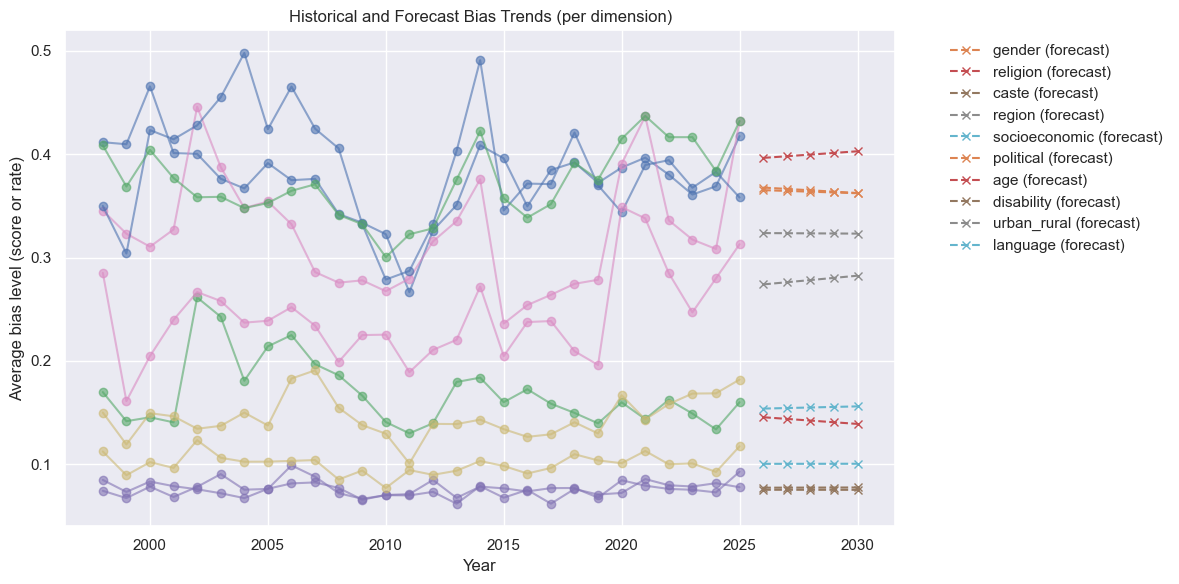


Notebook 15 Complete!


In [ ]:
forecast_rows = []
future_years = np.arange(2026, 2031)

for dim in BIAS_DIMENSIONS:
    sub = bias_yearly[bias_yearly["dimension"] == dim].dropna(subset=["avg_bias"])
    if len(sub) < 5:
        continue

    X = sub["year"].values.reshape(-1, 1)
    y = sub["avg_bias"].values

    lr = LinearRegression()
    lr.fit(X, y)

    preds = lr.predict(future_years.reshape(-1, 1))
    for year, pred in zip(future_years, preds):
        forecast_rows.append(
            {"dimension": dim, "year": int(year), "predicted_avg_bias": float(pred)}
        )

forecast_df = pd.DataFrame(forecast_rows)

if not forecast_df.empty:
    print(
        "\nForecasted bias trends for 2026-2030 (linear regression, yearly averages):"
    )
    print(
        forecast_df.pivot(
            index="year", columns="dimension", values="predicted_avg_bias"
        )
    )

    plt.figure(figsize=(12, 6))
    for dim in BIAS_DIMENSIONS:
        sub_hist = bias_yearly[bias_yearly["dimension"] == dim].sort_values("year")
        sub_fore = forecast_df[forecast_df["dimension"] == dim].sort_values("year")
        if sub_hist.empty or sub_fore.empty:
            continue
        plt.plot(sub_hist["year"], sub_hist["avg_bias"], marker="o", alpha=0.6)
        plt.plot(
            sub_fore["year"],
            sub_fore["predicted_avg_bias"],
            marker="x",
            linestyle="--",
            label=f"{dim} (forecast)",
        )

    plt.title("Historical and Forecast Bias Trends (per dimension)")
    plt.xlabel("Year")
    plt.ylabel("Average bias level (score or rate)")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

print("\nNotebook 15 Complete!")

### Key Insights: Historical and Forecast Bias Trends

1) Core bias dimensions remain persistently high over time – gender, political and age bias dominate historically, with noticeable ups and downs but no sustained decline, while caste, disability and language bias stay much lower throughout the period.
    
2) Forecasts suggest these patterns will largely persist – projected bias levels for 2026–2030 are roughly flat at recent values, indicating that without interventions the current hierarchy of biases (high for gender/political/age, moderate for region/socioeconomic/urban‑rural, low for caste/disability/language) is expected to continue.